# 1. Instalaciones necesarias

In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 17.4 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Leer los datos

In [ ]:
main_dir = '/content/drive/MyDrive/0tfm/RSNA/'
lables = 'stage_2_train_labels.csv'
lables_full = 'stage_2_detailed_class_info.csv'
images="stage_2_train_images/"

lables_dir = main_dir + lables
lables_full_dir = main_dir + lables_full
images_dir = main_dir + images

In [ ]:
df_lables = pd.read_csv(lables_dir)
print(df_lables.shape)
print(df_lables.iloc[4])

(30227, 6)
patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                           264.0
y                                           152.0
width                                       213.0
height                                      379.0
Target                                          1
Name: 4, dtype: object


In [ ]:
df_lables_full = pd.read_csv(lables_full_dir)
print(df_lables_full.shape)
print(df_lables_full.iloc[4])

(30227, 2)
patientId    00436515-870c-4b36-a041-de91049b9ab4
class                                Lung Opacity
Name: 4, dtype: object


In [ ]:
df=pd.concat((df_lables,df_lables_full.drop("patientId",axis=1)),axis=1)
df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [ ]:
df.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'Target', 'class'], dtype='object')

# 4.2.1.	Análisis exploratorio de datos

## 4.2.1.1. Distribución de pacientes con y sin neumonía según datos tabulares

In [ ]:
print("valores en la tabla ",df["patientId"].count())
print("pacientes unicos",len(np.unique(df["patientId"])))

valores en la tabla  30227
pacientes unicos 26684


In [ ]:
df.groupby('class')['patientId'].nunique()


,patientId
class,
Lung Opacity,6012
No Lung Opacity / Not Normal,11821
Normal,8851


## 4.2.1.2. Distribución de pacientes según el número de áreas con opacidad

In [ ]:
df.groupby(['patientId','Target'])['patientId'].count().value_counts()

,count
patientId,
1,23286
2,3266
3,119
4,13


## 4.2.1.3. Análisis visual de los centros de opacidades

In [ ]:
df['centro_x'] = df['x'] + (df['width'] / 2)
df['centro_y'] = df['y'] + (df['height'] / 2)
opacidades = df[pd.notna(df['x'])]
opacidades.head(3)

,patientId,x,y,width,height,Target,class,centro_x,centro_y
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,370.5,341.5
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,690.0,378.5
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,403.0,629.0


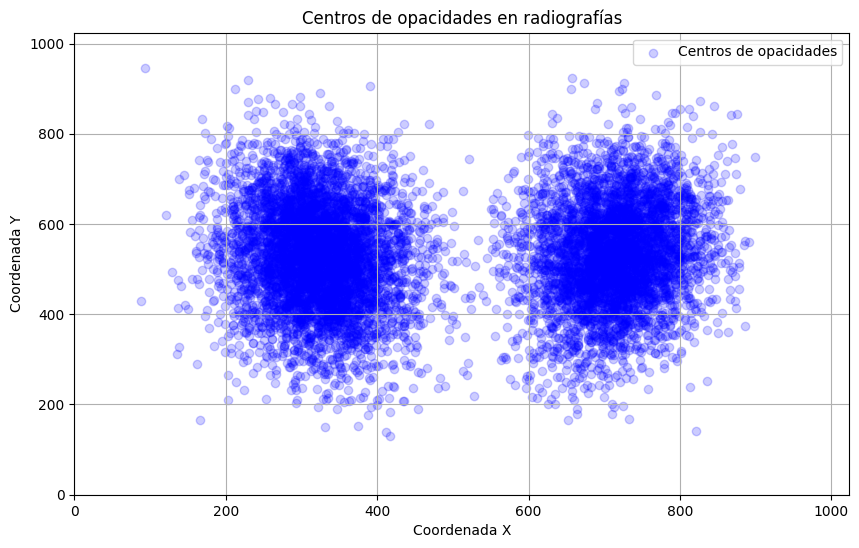

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(opacidades['centro_x'], opacidades['centro_y'], color='blue', label='Centros de opacidades', alpha=0.2)
plt.title('Centros de opacidades en radiografías')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.xlim(0, 1024)
plt.ylim(0, 1024)
plt.grid()
plt.legend()
plt.show()

## 4.2.1.4. Características técnicas de las imágenes

In [ ]:
id_example = df.loc[4,"patientId"]
dcm_data = pydicom.dcmread(main_dir + images + "/" + id_example + ".dcm")

In [ ]:
# Obter los datos de la imagen
pixel_array = dcm_data.pixel_array

# Dimensiones
dimensiones = pixel_array.shape
print(f"Dimensiones de la imagen: {dimensiones}")

Dimensiones de la imagen: (1024, 1024)


In [ ]:
# Número de canales
# Para imágenes 2D (grayscale), suele ser 1. Para imágenes en color, puede ser 3 (RGB) o 4 (RGBA)
if len(dimensiones) == 2:
    num_canales = 1
elif len(dimensiones) == 3:
    num_canales = dimensiones[2]
else:
    num_canales = 0  # No es una imagen válida

print(f"Número de canales: {num_canales}")

Número de canales: 1


In [ ]:
# Rango de valores de píxeles
min_valor = np.min(pixel_array)
max_valor = np.max(pixel_array)
print(f"Rango de valores de píxeles: {min_valor} - {max_valor}")

Rango de valores de píxeles: 0 - 255


## 4.2.1.5. Visualización de imágenes radiográficas

In [ ]:
def show_images_with_boxes(df, images_dir, num):
    # Filtrar las imágenes por clase
    classes = ['Normal', 'Lung Opacity', 'No Lung Opacity / Not Normal']
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))  # Crear una figura con 2 filas y 3 columnas

    # Recorrer cada clase y su respectivo subplot
    for i, cls in enumerate(classes):
        # Filtrar los datos para la clase actual
        patient_ids = df[df['class'] == cls]['patientId'].unique()

        # Tomar un paciente aleatorio de la clase
        if len(patient_ids) > 0:
            patient_id = patient_ids[num]

            # Cargar la imagen DICOM
            dicom_path = os.path.join(images_dir, f"{patient_id}.dcm")
            dicom_image = pydicom.dcmread(dicom_path)
            img = dicom_image.pixel_array

            # Normalizar la imagen
            img = img / img.max()

            # Dibujar la imagen
            axs[i].imshow(img, cmap='gray')
            axs[i].set_title(f"Class: {cls}", fontsize=20)
            axs[i].axis('off')

            # Dibujar las bounding boxes
            boxes = df[df['patientId'] == patient_id]
            for _, row in boxes.iterrows():
                rect = plt.Rectangle((row['x'], row['y']), row['width'], row['height'],
                                     fill=False, edgecolor='red', linewidth=2)
                axs[i].add_patch(rect)

    plt.tight_layout()
    plt.show()


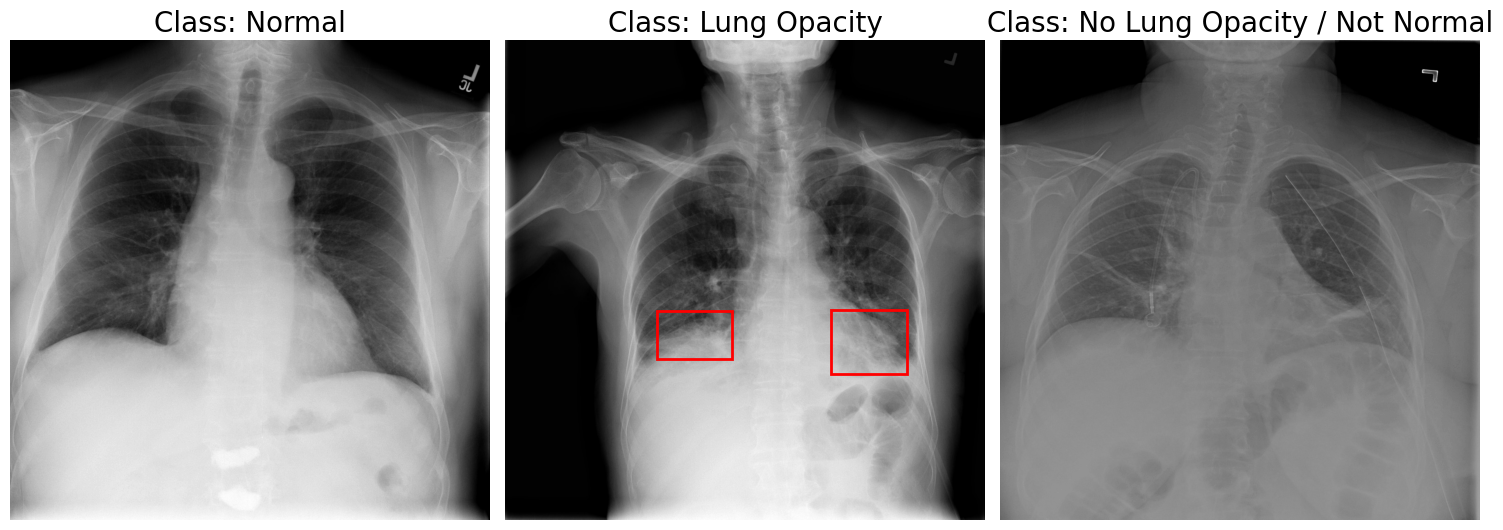

In [ ]:
show_images_with_boxes(df, images_dir,1)


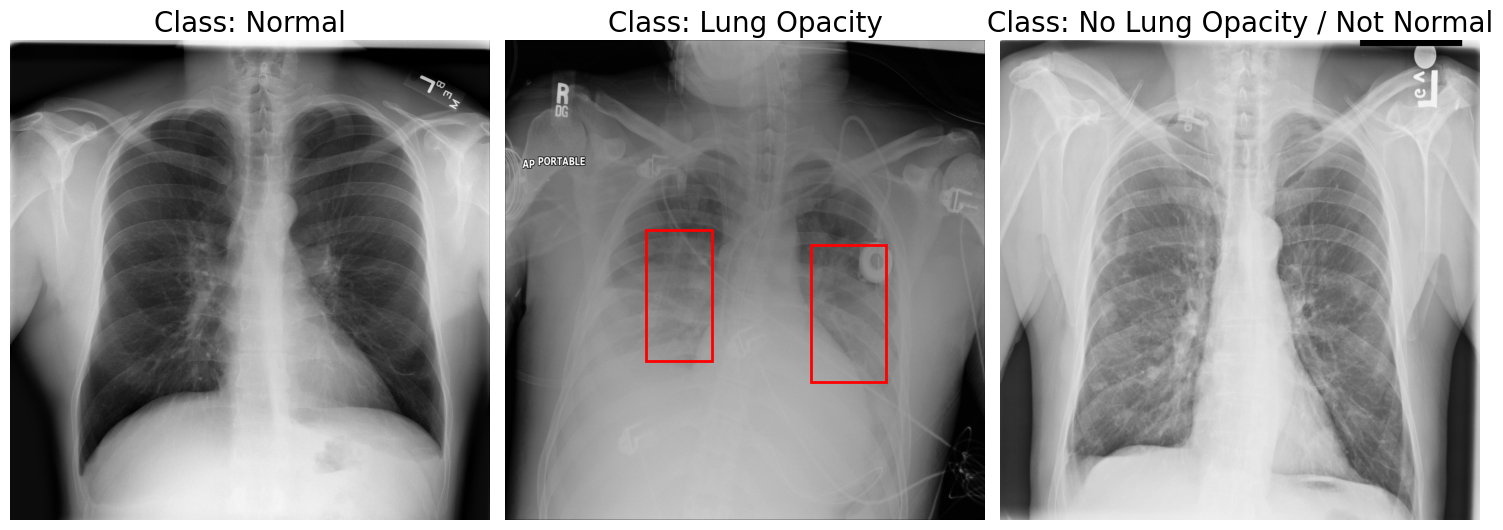

In [ ]:
show_images_with_boxes(df, images_dir,6)

## 4.2.1.6. Extracción y analisis de datos textuales de imágenes DICOM

In [ ]:
id_example = df.loc[4,"patientId"]
dcm_data = pydicom.dcmread(main_dir + images + "/" + id_example + ".dcm")
print(dcm_data)

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 200
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0002,0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002,0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002,0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0008,0020) Study Date                          DA: '19010101'
(0008,0030) Study Time                    

In [ ]:
df_extended = df.copy()
image_names = os.listdir(images_dir)
vars = ['PatientAge', 'PatientSex',  'ViewPosition']
for var in vars:
      df_extended[var] = None

def extract_data_dicom(df, data_path,):
    for i, img_name in tqdm(enumerate(image_names)):
        image_path = os.path.join(images_dir, img_name)
        img_metadata = pydicom.dcmread(image_path)
        patient_id = (df['patientId']==img_metadata.PatientID)
        df.loc[patient_id, 'PatientAge'] = pd.to_numeric(img_metadata.PatientAge, errors='coerce')
        df.loc[patient_id, 'PatientSex'] = img_metadata.PatientSex
        df.loc[patient_id, 'ViewPosition'] = img_metadata.ViewPosition

extract_data_dicom (df_extended , images_dir)

26590it [22:02, 20.11it/s]


In [ ]:
df_extended.to_csv('df_extended.csv', index=False)
print("fichero con metadata de ficheros DCOM esta guardado")

fichero con metadata de ficheros DCOM esta guardado


In [ ]:
df_guardado=pd.read_csv(main_dir + 'df_extended.csv')
print("fichero con metadata de ficheros DCOM esta leido desde Drive")
df_guardado.head()

fichero con metadata de ficheros DCOM esta leido desde Drive


,patientId,x,y,width,height,Target,class,PatientAge,PatientSex,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,51.0,F,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,48.0,F,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,19.0,M,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,28.0,M,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,32.0,F,AP


### Distribución de neumonía según el sexo

In [ ]:
df_guardado=pd.read_csv(main_dir + 'df_extended.csv')
df=df_guardado.copy()
df['centro_x'] = df['x'] + (df['width'] / 2)
df['centro_y'] = df['y'] + (df['height'] / 2)

In [ ]:
# Contar las ocurrencias de cada valor de 'Target' en cada grupo de 'PatientSex'
df_counts = df_guardado.groupby('PatientSex')['Target'].value_counts()

# Obtener el total de cada grupo 'PatientSex'
df_totals = df_guardado['PatientSex'].value_counts()

# Dividir los conteos por el total de cada grupo
df_percentage = df_counts / df_totals

# Multiplicar por 100 para obtener el porcentaje
df_percentage = df_percentage * 100

# Mostrar el resultado
print(df_percentage)

PatientSex  Target
F           0         69.230769
            1         30.769231
M           0         67.627831
            1         32.372169
Name: count, dtype: float64


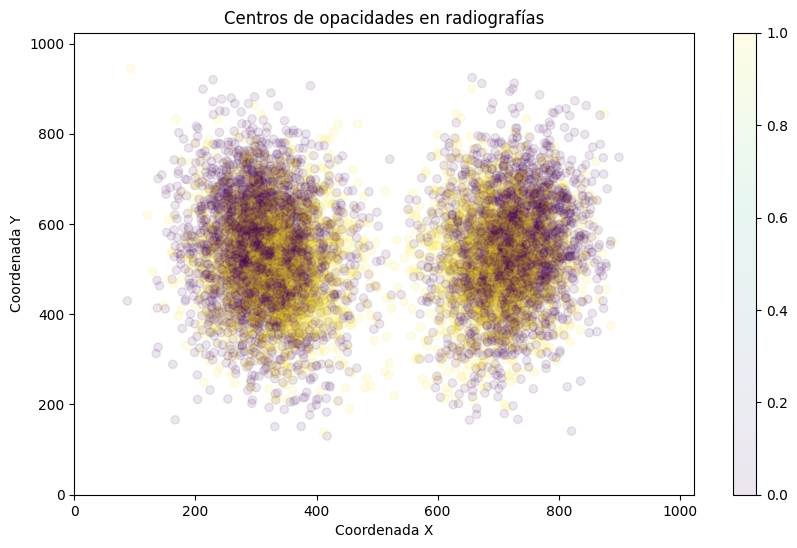

In [ ]:
df['PatientSex_num']=df['PatientSex'].map({'M': 0, 'F': 1})
plt.figure(figsize=(10, 6))
plt.scatter(df['centro_x'], df['centro_y'], c=df['PatientSex_num'], label='Centros de opacidades', alpha=0.1)
plt.title('Centros de opacidades en radiografías')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.xlim(0, 1024)
plt.ylim(0, 1024)
plt.colorbar()
plt.show()

### Distribución de neumonía según proyección AP/PA

In [ ]:
# Contar las ocurrencias de cada valor de 'Target' en cada grupo de 'PatientSex'
df_counts = df_guardado.groupby('ViewPosition')['Target'].value_counts()

# Obtener el total de cada grupo 'PatientSex'
df_totals = df_guardado['ViewPosition'].value_counts()

# Dividir los conteos por el total de cada grupo
df_percentage = df_counts / df_totals

# Multiplicar por 100 para obtener el porcentaje
df_percentage = df_percentage * 100

# Mostrar el resultado
print(df_percentage.sort_index())


ViewPosition  Target
AP            0         49.012532
              1         50.987468
PA            0         88.113017
              1         11.886983
Name: count, dtype: float64


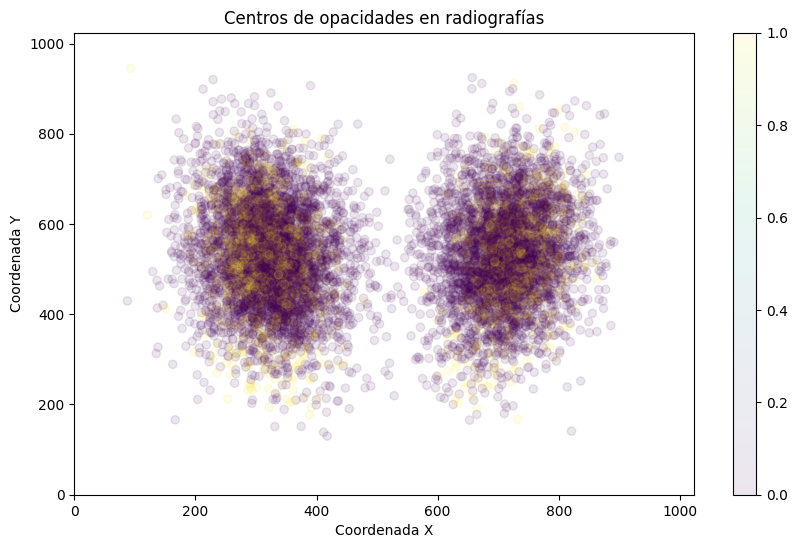

In [ ]:
df['ViewPosition_num']=df['ViewPosition'].map({'AP': 0, 'PA': 1})
plt.figure(figsize=(10, 6))
plt.scatter(df['centro_x'], df['centro_y'], c=df['ViewPosition_num'], label='Centros de opacidades', alpha=0.1)
plt.title('Centros de opacidades en radiografías')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.xlim(0, 1024)
plt.ylim(0, 1024)
plt.colorbar()
plt.show()

### Distribución de neumonía según edad

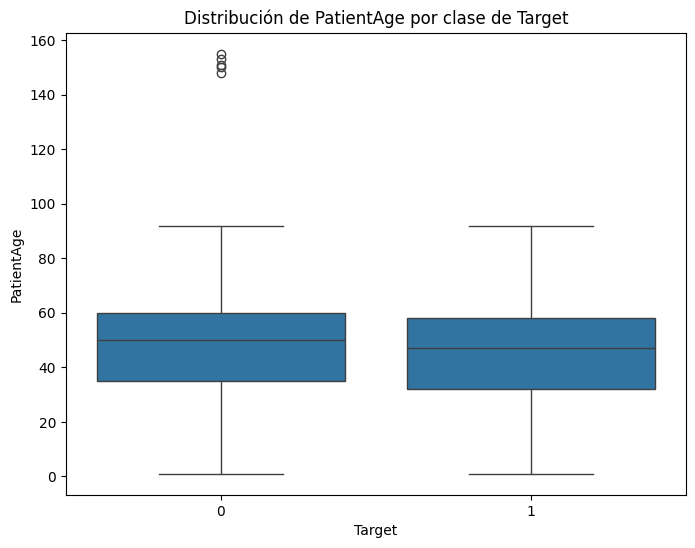

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el gráfico de bigotes
plt.figure(figsize=(8, 6))
sns.boxplot(x='Target', y='PatientAge', data=df_guardado)

# Añadir título y etiquetas
plt.title('Distribución de PatientAge por clase de Target')
plt.xlabel('Target')
plt.ylabel('PatientAge')

# Mostrar el gráfico
plt.show()

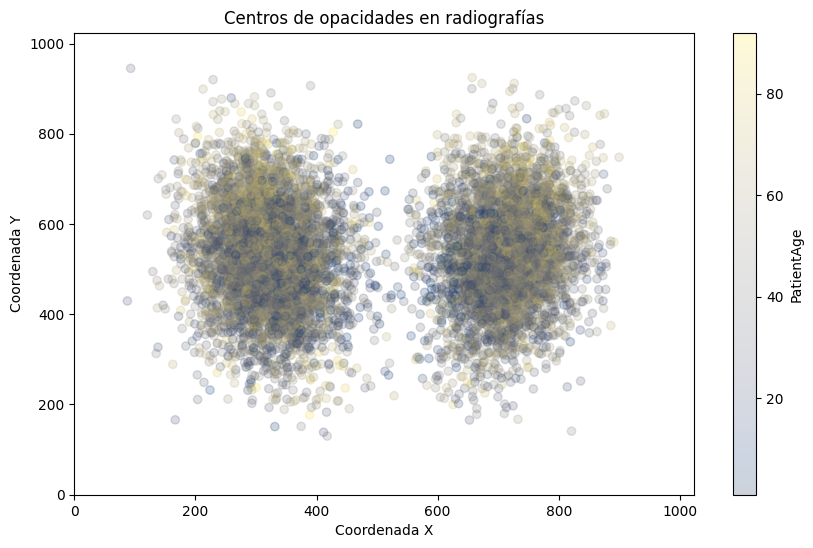

In [ ]:

plt.figure(figsize=(10, 6))
plt.scatter(df['centro_x'], df['centro_y'], c=df['PatientAge'], label='Centros de opacidades', alpha=0.2, cmap='cividis')
plt.title('Centros de opacidades en radiografías')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.xlim(0, 1024)
plt.ylim(0, 1024)
plt.colorbar(label='PatientAge')
plt.show()

## Valores nulos

In [ ]:
df_guardado.isna().sum()

,0
patientId,0
x,20672
y,20672
width,20672
height,20672
Target,0
class,0
PatientAge,121
PatientSex,121
ViewPosition,121


## Valores atipicos

In [ ]:
df_guardado.describe()

,x,y,width,height,Target,PatientAge
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000,30106.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108,46.795755
std,204.574172,148.940488,59.289475,157.750755,0.464963,16.895200
min,2.000000,2.000000,40.000000,45.000000,0.000000,1.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000,34.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000,49.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000,59.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000,155.000000


In [ ]:
df_guardado.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'Target', 'class',
       'PatientAge', 'PatientSex', 'ViewPosition'],
      dtype='object')

In [ ]:
df_one_hot = pd.get_dummies(df_guardado.drop(["patientId",'class'], axis=1), columns=['PatientSex', 'ViewPosition'], prefix='cat')
df_one_hot.head()

,x,y,width,height,Target,PatientAge,cat_F,cat_M,cat_AP,cat_PA
0,NaN,NaN,NaN,NaN,0,51.0,True,False,False,True
1,NaN,NaN,NaN,NaN,0,48.0,True,False,False,True
2,NaN,NaN,NaN,NaN,0,19.0,False,True,True,False
3,NaN,NaN,NaN,NaN,0,28.0,False,True,False,True
4,264.0,152.0,213.0,379.0,1,32.0,True,False,True,False


<Axes: >

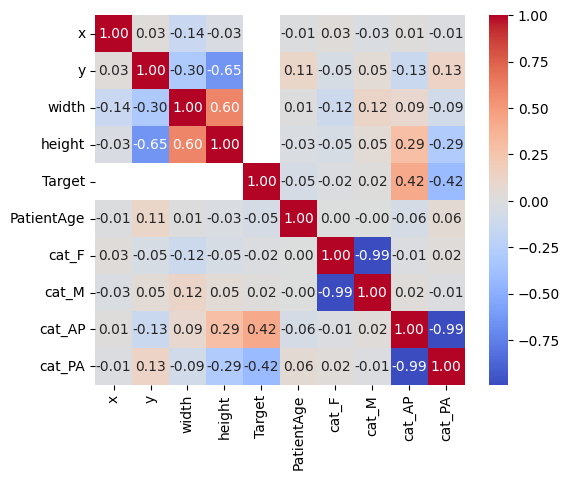

In [ ]:
correlation_matrix = df_one_hot.corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)